# Chi$^2$ and MCMC Fitting of Synthetic Spectrum to Stellar Spectra
this program demonstrates how to fit a synthetic spectrum to stellar spectral data using Chi$^2$ minimization and MCMC statistical methods.

In [31]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d
from scipy.stats import chisquare
import emcee
import corner
from tqdm import tqdm

In [2]:
file = 'spec1d_DE.20110603.45055-n7006a_DEIMOS_2011Jun03T123053.021.fits'

In [4]:
# Code to view file contents
def load_fits(file):
    """
    takes fits file and reads it into python
    """
    hdu = fits.open(file)
    return hdu

hdu = load_fits(file)
print(hdu[0].header)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  VERSPYT = '3.8.6   '           / Python version                                 VERSNPY = '1.19.4  '           / Numpy version                                  VERSSCI = '1.5.3   '           / Scipy version                                  VERSAST = '4.1     '           / Astropy version                                VERSSKL = '0.23.2  '           / Scikit-learn version                           VERSPYP = '1.4.0   '           / PypeIt version                                 DATE    = '2021-05-13'         / UTC date created                               RA      =    315.3602083333333 / (J2000) RA in decimal degrees                  DEC     =    16.21883333333333 / (J2000)

#### For each of the three stars, plot the wavelength versus counts

In [5]:
SPAT121 = hdu[121]
SPAT135 = hdu[135]
SPAT157 = hdu[157]

SPAT121w = SPAT121.data['OPT_WAVE']
SPAT121f = SPAT121.data['OPT_COUNTS']
SPAT121var = SPAT121.data['OPT_COUNTS_NIVAR']

SPAT135w = SPAT135.data['OPT_WAVE']
SPAT135f = SPAT135.data['OPT_COUNTS']
SPAT135var = SPAT135.data['OPT_COUNTS_NIVAR']

SPAT157w = SPAT157.data['OPT_WAVE']
SPAT157f = SPAT157.data['OPT_COUNTS']
SPAT157var = SPAT157.data['OPT_COUNTS_NIVAR']

In [56]:
def plot_three_spectra(wavelengths, counts, model = None):
    '''plots the spectra of each star on a 3 panel plot
    wavelengths [numpy array]: list of wavelengths of each star spectrum
    counts [numpy array]: list of counts of each star spectrum
    model [numpy array]: list of model spectrum of each star
    '''
    fig, axs = plt.subplots(3, 1, sharex = False, sharey = False, figsize=(15, 15))

    plt.rcParams['font.family'] = 'Courier New'

    # minor ticks
    axs[0].minorticks_on()
    axs[1].minorticks_on()
    axs[2].minorticks_on()
    axs[0].tick_params(which = 'minor', length = 4, direction = 'in', top = True, right = True)
    axs[1].tick_params(which = 'minor', length = 4, direction = 'in', top = True, right = True)
    axs[2].tick_params(which = 'minor', length = 4, direction = 'in', top = True, right = True)
    colors = ['darkslateblue', 'purple', 'orchid']
    labels = ['121', '135', '157']
    # plotting
    for index, wave in enumerate(wavelengths):
        axs[index].plot(wave, counts[index], label = labels[index], color = colors[index])
        if model is not None:
            axs[index].plot(wave, model[index], color = 'red', label = 'smoothed spectra', lw = 2)

    # formatting
    axs[0].set_ylabel('Φ', size = 18)
    axs[1].set_ylabel('Φ', size = 18)
    axs[2].set_ylabel('Φ', size = 18)
    axs[2].set_xlabel('\u03BB', size = 20)

    axs[0].set_xlim(8300, 8800)
    axs[1].set_xlim(8300, 8800)
    axs[2].set_xlim(8300, 8800)
    axs[2].set_ylim(1100,4100)
    a = axs[0].legend(loc = 'lower right', prop={'family': 'sans-serif', 'size': 12})
    b = axs[1].legend(loc = 'lower right', prop={'family': 'sans-serif', 'size': 12})
    c = axs[2].legend(loc = 'lower right', prop={'family': 'sans-serif', 'size': 12})

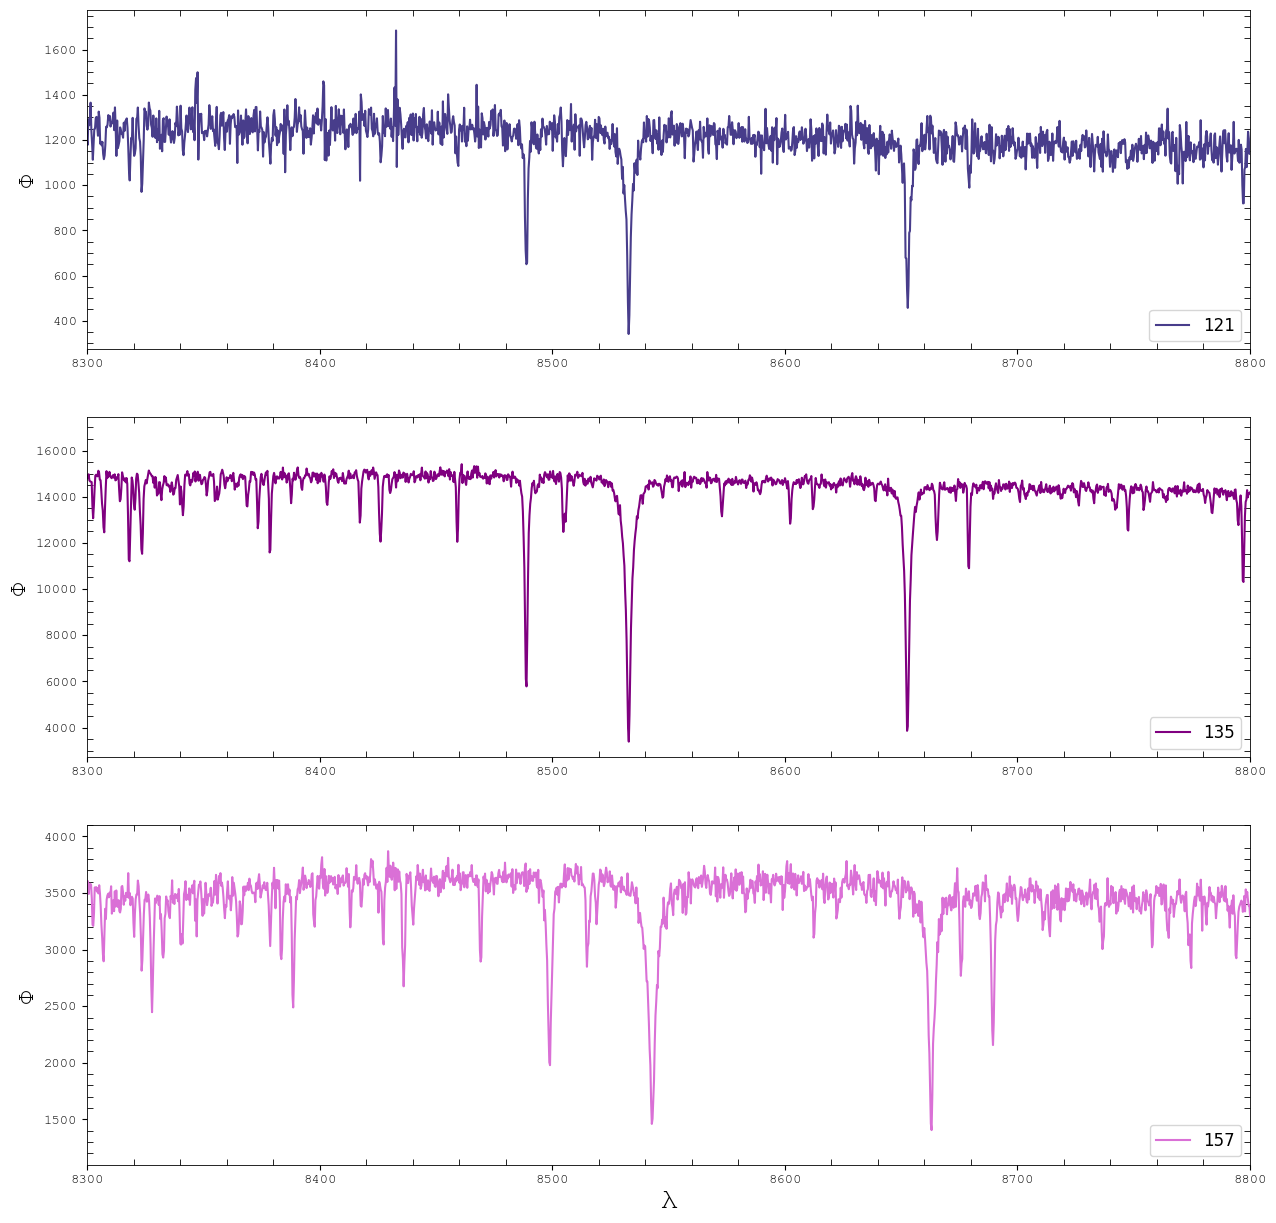

In [58]:
plot_three_spectra([SPAT121w, SPAT135w, SPAT157w], [SPAT121f, SPAT135f, SPAT157f])

In [12]:
template_file = 'dmost_lte_5500_3.0_-1.0_.fits'
def read_synthetic_spectrum(pfile):
    '''
    Function to load synthetic template file into python using vacuum wavelengths
    
    Parameters
    ----------
    pfile: str
        path to the synthitic fits file to load. 
        
    Returns
    -------
    pwave: float array
        Wavelengths of synthetic spectrum
    pflux: float array
        Flux of sythetic spectrum
    '''

    with fits.open(pfile) as hdu:
        data     = hdu[1].data
        
    pflux = np.array(data['flux']).flatten()
    awave = np.exp((data['wave']).flatten())
    

    # CONVERTING AIR WAVELENGTHS TO VACUUM
    s = 10**4 / awave
    n = 1. + 0.00008336624212083 + \
            (0.02408926869968 / (130.1065924522 - s**2)) +\
            (0.0001599740894897 / (38.92568793293 - s**2))

    pwave  = awave*n
    
    return pwave, pflux

# Read in synthetic spectra and plot wavelegth versus flux
pwave, pflux = read_synthetic_spectrum(template_file)

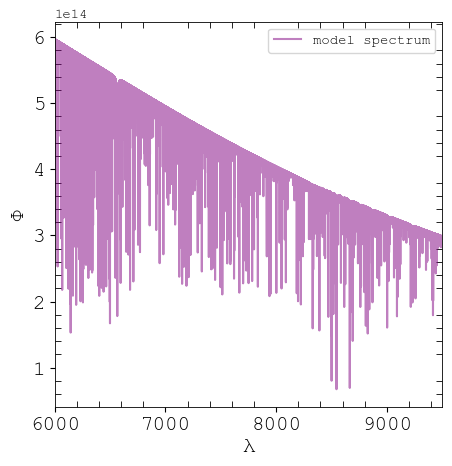

In [63]:
fig, ax = plt.subplots(figsize = (5, 5))

plt.rcParams['font.family'] = 'Courier New'
ax.minorticks_on()
ax.tick_params(which = 'minor', length = 4, direction = 'in', top = True, right = True)
plt.rcParams['axes.linewidth'] = 0.6
ax.tick_params(labelsize = 15)

plt.plot(pwave, pflux, color = 'purple', label = 'model spectrum', alpha = .5)

plt.xlabel('\u03BB', size = 15)
plt.ylabel('Φ', size = 15)

plt.legend(prop={'family': 'Courier New', 'size': 10})

a = plt.xlim(6000, 9500)

In [14]:
# Write a function to Gaussian smooth the synthtic spectrum, using a smoothing kernal of 25 pixels.
new_flux = scipy.ndimage.gaussian_filter(pflux, sigma = 25)

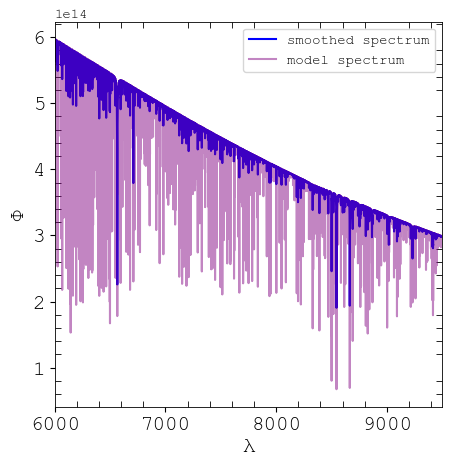

In [21]:
fig, ax = plt.subplots(figsize = (5, 5))

plt.rcParams['font.family'] = 'Courier New'
ax.minorticks_on()
ax.tick_params(which = 'minor', length = 4, direction = 'in', top = True, right = True)
plt.rcParams['axes.linewidth'] = .6
ax.tick_params(labelsize = 15)

plt.plot(pwave, new_flux, color = 'blue', label = 'smoothed spectrum')
plt.plot(pwave, pflux, alpha = .48, color = 'purple', label = 'model spectrum')
#plt.plot(xspace, wavelength, color = 'red')

plt.xlabel('\u03BB', size = 15)
plt.ylabel('Φ', size = 15)

plt.legend(prop={'family': 'Courier New', 'size': 10})

a = plt.xlim(6000, 9500)

In [33]:
# Write a function to rebin the synthetic template.
def rebin_spectra(wavelength):  
    """
    takes in science wavelength array and uses it to rebin/interpolate the synthetic flux to the values 
    of the science wavelength array
    """
    model = interp1d(pwave, new_flux)
    return model(wavelength)

# Write a function to match continuum shape of a science spectrum.
def match_continuum(synthflux, sciencewave, scienceflux):
    """
    calculates the required transformation to match the continuum of the synthetic spectra to the observed data.
    returns a matched synthetic flux array
    _____________________________________________________________________________________________________________
    
    synthflux = synthetic flux
    
    sciencewave = observed wavelength
    
    scienceflux = observed flux
    """
    y = scienceflux / synthflux
    poly = np.polyfit(sciencewave, y, 2)
    transform = np.poly1d(poly)
    return synthflux * transform(sciencewave)

In [36]:
# Run both functions (smooth + rebin/continumm) and plot your smoothed, continuum normalized synthetic spectrum
interp_flux121 = rebin_spectra(SPAT121w)
interp_flux135 = rebin_spectra(SPAT135w)
interp_flux157 = rebin_spectra(SPAT157w)

match_flux121 = match_continuum(interp_flux121, SPAT121w, SPAT121f)
match_flux135 = match_continuum(interp_flux135, SPAT135w, SPAT135f)
match_flux157 = match_continuum(interp_flux157, SPAT157w, SPAT157f)

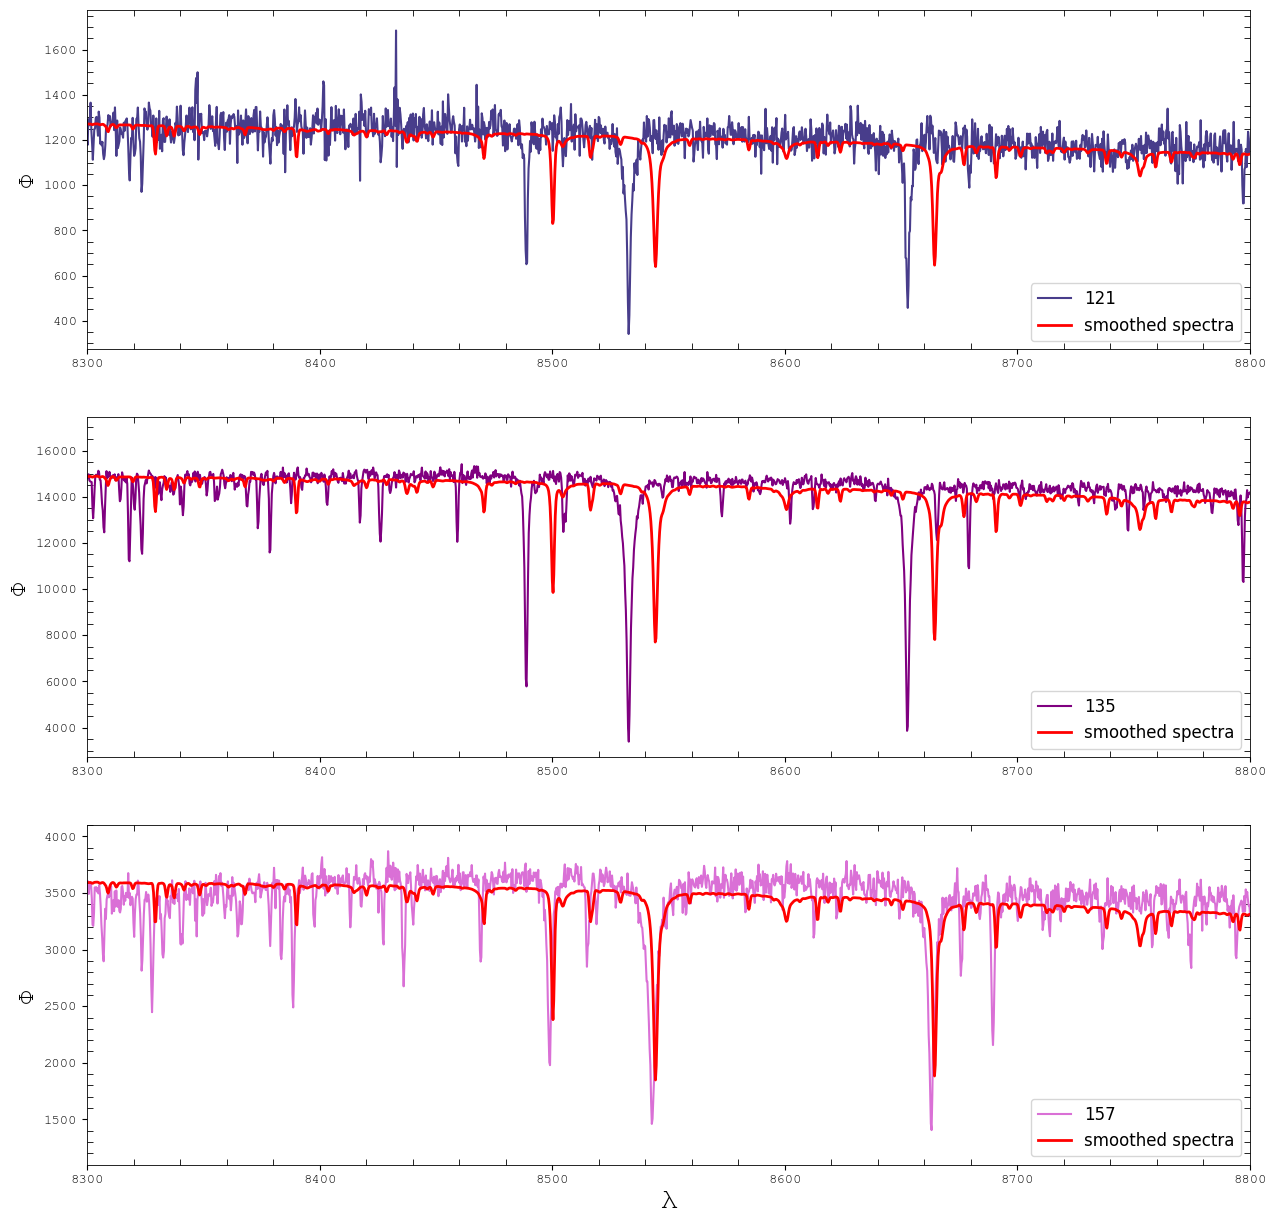

In [64]:
plot_three_spectra([SPAT121w, SPAT135w, SPAT157w], [SPAT121f, SPAT135f, SPAT157f], [match_flux121, match_flux135, match_flux157])

### Chi$^2$ fitting searching over 2 parameters: velocity, smoothing 
#### Calculate errors from your chi2 contours on the velocity only.

In [27]:
def f_xi(init, velocity, c = 299792):
    """
    calculates shifted wavelength given an initial wavelength and velocity
    _______________________________________________________________________
    
    init = synthetic wavelength
    
    velocity = velocity value used to shift wavelength
    """
    return (init * (velocity / c)) + init

In [23]:
def Chi_2param(synth_i, synth_f, sci_i, flux, velocity, smoothing, inv_variance):
    """
    calculates Chi2 for two parameters
    ___________________________________
    
    synth_i = initial synthetic wavelength array; pwave
    
    synth_f = initial synthetic flux array; pflux
    
    sci_i = initial science wavelength array
    
    flux = initial science flux array
    
    velocity = array of velocities to be searched over
    
    smoothing = array of smoothing values to be searched over
    """
    # calculate wavelength shift
    shifted_wavelength = f_xi(synth_i, velocity, c = 299792)
    
    # smooth 
    smooth_flux = scipy.ndimage.gaussian_filter(synth_f, sigma = smoothing)
    
    # rebin and match
    model = interp1d(shifted_wavelength, smooth_flux)
    interp_flux = model(sci_i)
    match = match_continuum(interp_flux, sci_i, flux)
    
    # calculate Chi2
    chi2 = ((flux - match)**2)*(inv_variance)
    chi2_sum = np.sum(chi2)
    return chi2_sum

In [65]:
# SPAT121
velo_grid = np.linspace(-600, 600, 90)
smooth_grid = np.linspace(10,50, 90)

chi_min = 2e32
velo_min, smooth_min = 0, 0 

varray, sarray, chi2 = [],[],[]

chi_2_zero = np.zeros((90, 90))

for i, v in tqdm(enumerate(velo_grid)):
    for j, s in enumerate(smooth_grid):
        c = (Chi_2param(synth_i = pwave, synth_f = pflux, sci_i = SPAT121w, flux = SPAT121f, 
                            velocity = v, smoothing = s, inv_variance = SPAT121var))
        chi_2_zero[i, j] = c
        chi2.append(c)
        varray.append(v)
        sarray.append(s)
        
        if c < chi_min:
            chi_min = c
            velo_min = v
            smooth_min = s

chi2 = np.array(chi2)
varray = np.array(varray)
sarray = np.array(sarray)
        
print('minimum velocity shift: ', {velo_min})
print('minimum smoothing value:', {smooth_min})

print('minimum \u03C7\u00b2:             ', {np.min(chi_2_zero)})

90it [02:46,  1.85s/it]

minimum velocity shift:  {-397.75280898876406}
minimum smoothing value: {19.43820224719101}
minimum χ²:              {82322.83601062055}


In [66]:
m = (np.min(chi2)+1.)
msk = (chi2 < m)
v_err = (np.max(varray[msk]) - np.min(varray[msk]))/2.
s_err = (np.max(sarray[msk]) - np.min(sarray[msk]))/2.
print('Best fit velocity:', velo_min, '±', v_err)
print('Best fit smoothing:', smooth_min, '±', s_err)

Best fit velocity: -397.75280898876406 ± 0.0
Best fit smoothing: 19.43820224719101 ± 0.0


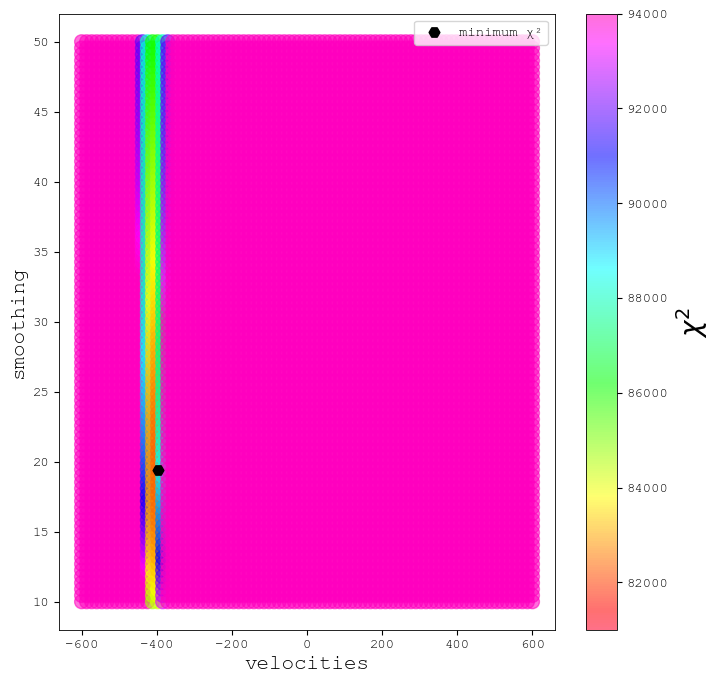

In [74]:
fig, ax = plt.subplots(figsize = (8, 8))

plot = plt.scatter(varray, sarray, vmin = 81000, vmax = 94000, s = 100, c = chi_2_zero, cmap = 'gist_rainbow',
                  alpha = .56)
colorbar = plt.colorbar(plot).set_label(label = r'$\chi^{2}$', size = 20)

plt.xlabel('velocities', size = 15)
plt.ylabel('smoothing', size = 15)

plt.scatter(-397.75280898876406, 19.43820224719101, color = 'black', s = 60, marker = 'H', 
            label = 'minimum \u03C7\u00b2')

a = plt.legend(prop={'family': 'Courier New', 'size': 10})

In [75]:
# shift synthetic wavelengths by minimized velocity
v121 = f_xi(pwave, velocity = -397.75280898876406, c = 299792)
v135 = f_xi(pwave, velocity = -411.2359550561798, c = 299792)
v157 = f_xi(pwave, velocity = -47.1910112359551, c = 299792)
# smooth flux
sflux121 = scipy.ndimage.gaussian_filter(pflux, sigma = 19.43820224719101)
sflux135 = scipy.ndimage.gaussian_filter(pflux, sigma = 15.842696629213483)
sflux157 = scipy.ndimage.gaussian_filter(pflux, sigma = 16.29213483146067)

In [76]:
def bin121(wavelength):   
    model = interp1d(v121, sflux121)
    return model(wavelength)
def bin135(wavelength):   
    model = interp1d(v135, sflux135)
    return model(wavelength)
def bin157(wavelength):   
    model = interp1d(v157, sflux157)
    return model(wavelength)
i121 = bin121(SPAT121w)
i135 = bin135(SPAT135w)
i157 = bin157(SPAT157w)

m121 = match_continuum(i121, SPAT121w, SPAT121f)
m135 = match_continuum(i135, SPAT135w, SPAT135f)
m157 = match_continuum(i157, SPAT157w, SPAT157f)

## plot the spectra with the newly fitted model

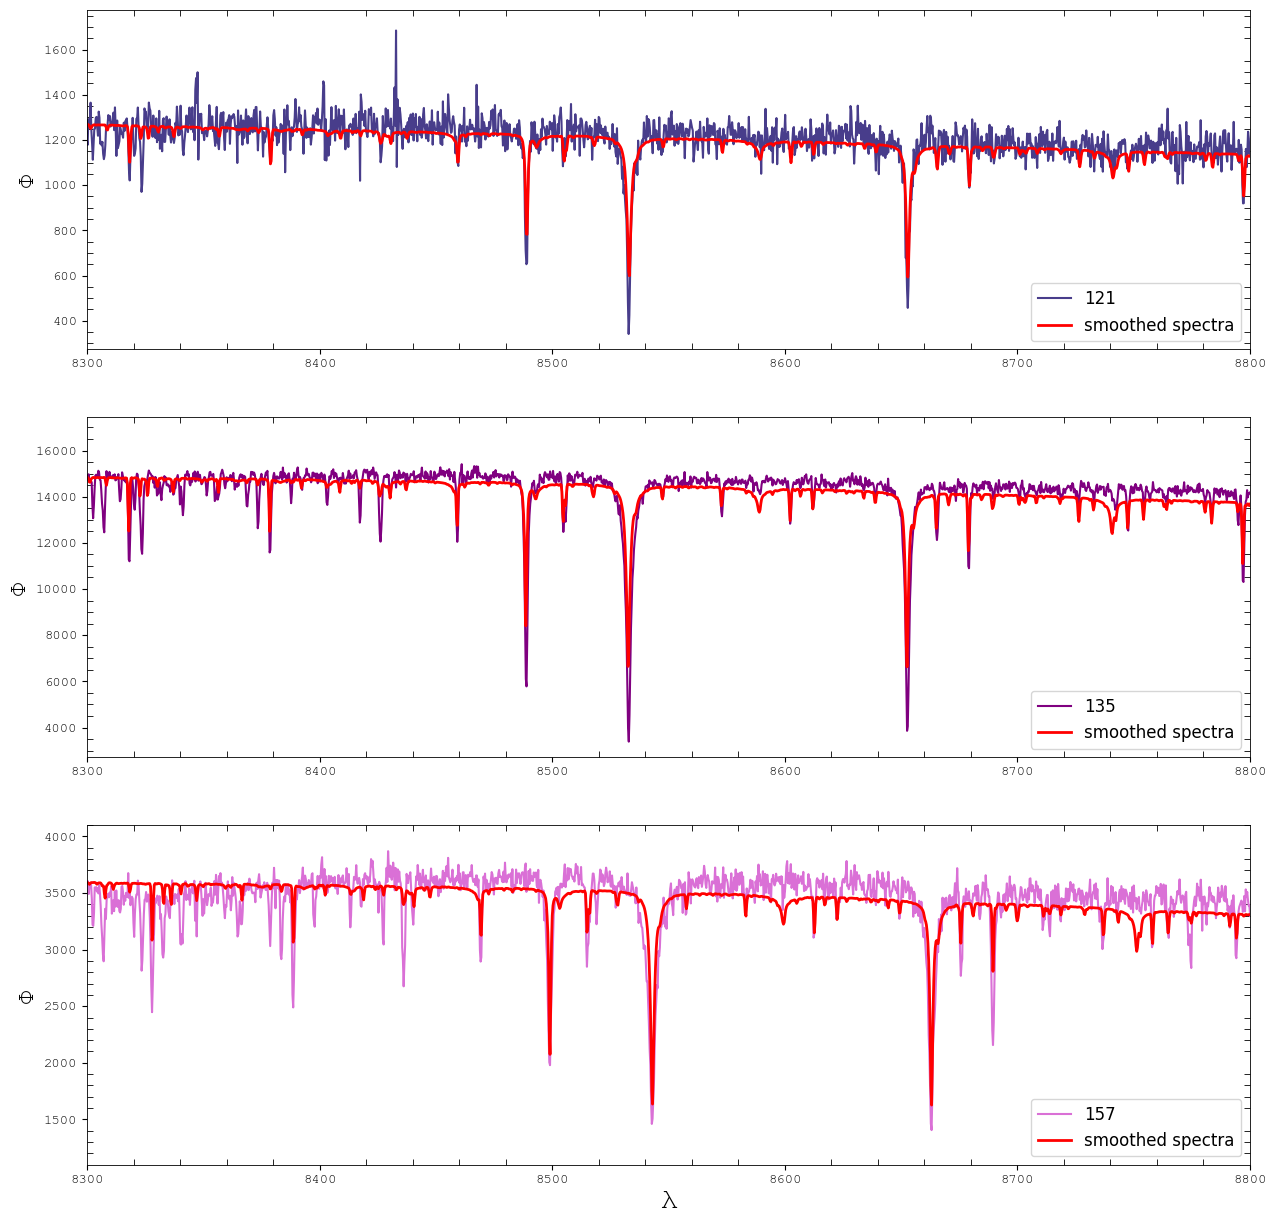

In [77]:
plot_three_spectra([SPAT121w, SPAT135w, SPAT157w], [SPAT121f, SPAT135f, SPAT157f], [m121, m135, m157])

# MCMC

In [82]:
def MCMC(synth_i, synth_f, sci_i, flux, inv_variance, init_v, init_s):
    
    """
    This function performs MCMC on spectral data using synthetic spectra as a model.
    _________________________________________________________________________________
    
    synth_i = initial synthetic wavelength array; pwave                             
    
    synth_f = initial synthetic flux array; pflux                                   
    
    sci_i = initial science wavelength array                                        

    flux = initial science flux array                                               
    
    init_v = initial velocity guess                                                 
    
    init_s = initial smoothing guess 
    
    """
    def model(theta, synth_i, synth_f, sci_i, flux, inv_variance):
    
        velocity, smoothing = theta
    
        # calculate wavelength shift
        shifted_wavelength = f_xi(synth_i, velocity, c = 299792)
    
        # smooth 
        smooth_flux = scipy.ndimage.gaussian_filter(synth_f, sigma = smoothing)
       
        # rebin and match
        model = interp1d(shifted_wavelength, smooth_flux)
        interp_flux = model(sci_i)
        match = match_continuum(interp_flux, sci_i, flux)
        return match
    
    def lnlike(theta, synth_i, synth_f, sci_i, flux, inv_variance):
        return -0.5 * np.sum((((flux - model(theta, synth_i, synth_f, 
                                             sci_i, flux, inv_variance))**2)*inv_variance))
    
    def lnprior(theta):
        velocity, smoothing = theta
        
        if (-420 < velocity < -390) & (13 < smoothing < 22):
            return 0.0
        return -np.inf
    
    def lnprob(theta, synth_i, synth_f, sci_i, flux, inv_variance):
        lp = lnprior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + lnlike(theta, synth_i, synth_f, sci_i, flux, inv_variance)
    
    data = (synth_i, synth_f, sci_i, flux, inv_variance)
    nwalkers = 20
    niter = 2000
    initial = np.array([init_v, init_s])
    ndim = len(initial)
    p0 = [np.array(initial) + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]
    
    def main(p0, nwalkers, niter, ndim, lnprob, data):
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args = data)

        print("Running burn-in...")
        p0, _, _ = sampler.run_mcmc(p0, 100, progress = True)
        sampler.reset()

        print("Running production...")
        pos, prob, state = sampler.run_mcmc(p0, niter, progress = True)

        return sampler, pos, prob, state
    
    sampler, pos, prob, state = main(p0, nwalkers, niter, ndim, lnprob, data)
    
    # plot highest likelihood model
    
    fig, ax = plt.subplots(figsize = (16, 5))
    plt.rcParams['font.family'] = 'sans-serif'
    ax.minorticks_on()
    ax.tick_params(which = 'minor', length = 4, direction = 'in', top = True, right = True)
    plt.rcParams['axes.linewidth'] = 2
    ax.tick_params(labelsize = 15)

    sampling = sampler.flatchain
    theta_max = sampling[np.argmax(sampler.flatlnprobability)]
    best_fit_model = model(theta_max, synth_i, synth_f, sci_i, flux, inv_variance)

    plt.plot(sci_i, flux, color = 'mediumslateblue')
    plt.plot(sci_i, best_fit_model, color = 'red', label = 'Highest Likelihood Model', linewidth = 2)


    plt.legend(loc = 'best', prop={'family': 'sans-serif', 'size': 15}, markerscale = 70)

    plt.xlabel('\u03BB', size = 20)
    plt.ylabel('Φ', size = 20)
    plt.xlim(8300, 8800)
    
    # sample chains
    
    fig, axs = plt.subplots(1, 2, sharex = False, sharey = False, figsize=(20, 3))
    plt.rcParams['font.family'] = 'sans-serif'
    # minor ticks
    axs[0].minorticks_on()
    axs[1].minorticks_on()
    axs[0].tick_params(which = 'minor', length = 4, direction = 'in', top = True, right = True)
    axs[1].tick_params(which = 'minor', length = 4, direction = 'in', top = True, right = True)

    for i in range(20):
        axs[0].plot(sampler.chain[i,:,0], color = 'k', linewidth = 0.5, alpha = .6)

    for i in range(20):
        axs[1].plot(sampler.chain[i,:,1], color = 'k', linewidth = 0.5, alpha = .6)

    tau    = sampler.get_autocorr_time(tol=0)
    burnin = int(2 * np.max(tau))
    
    axs[0].set_ylabel('velocity', size = 15)
    axs[1].set_ylabel('smoothing', size = 15)
    axs[0].set_xlabel('step number', size = 15)
    axs[1].set_xlabel('step number', size = 15)

    axs[0].set_title('velocity sample chains')
    axs[1].set_title('smoothing sample chains')

    axs[0].axvline(burnin, label = 'burn-in')
    axs[1].axvline(burnin, label = 'burn-in')
    
    a = axs[0].legend(prop={'family': 'sans-serif', 'size': 15})
    b = axs[1].legend(prop={'family': 'sans-serif', 'size': 15})
    
    # plot corner plot
    
    fig = plt.figure(figsize = (10,10))
    labels = ['velocity', 'smoothing']
    fig = corner.corner(sampling, labels = labels, show_titles = True, plot_datapoints = True, bins = 50, 
                    top_ticks = True, fig = fig, quantiles = [0.16, 0.5, 0.84], 
                    truths = [theta_max[0], theta_max[1]], truth_color = 'red')
    
    #test convergence
    
    def convergence(samples):
        tau = emcee.autocorr.integrated_time(samples, tol=0)
        num = samples.shape[0] * samples.shape[1]
        converged = np.all(tau * 100 < num)
        converged &= np.all(len(samples) > 50 * tau)
        return print('converged: ', converged)
    
    convergence(sampling)
    print('[wavelength, velocity]: ', theta_max)


Running burn-in...


100%|█████████████████████████████████████████| 100/100 [00:20<00:00,  4.94it/s]


Running production...


100%|███████████████████████████████████████| 2000/2000 [08:06<00:00,  4.11it/s]


converged:  True
[wavelength, velocity]:  [-403.72067488   17.37310273]


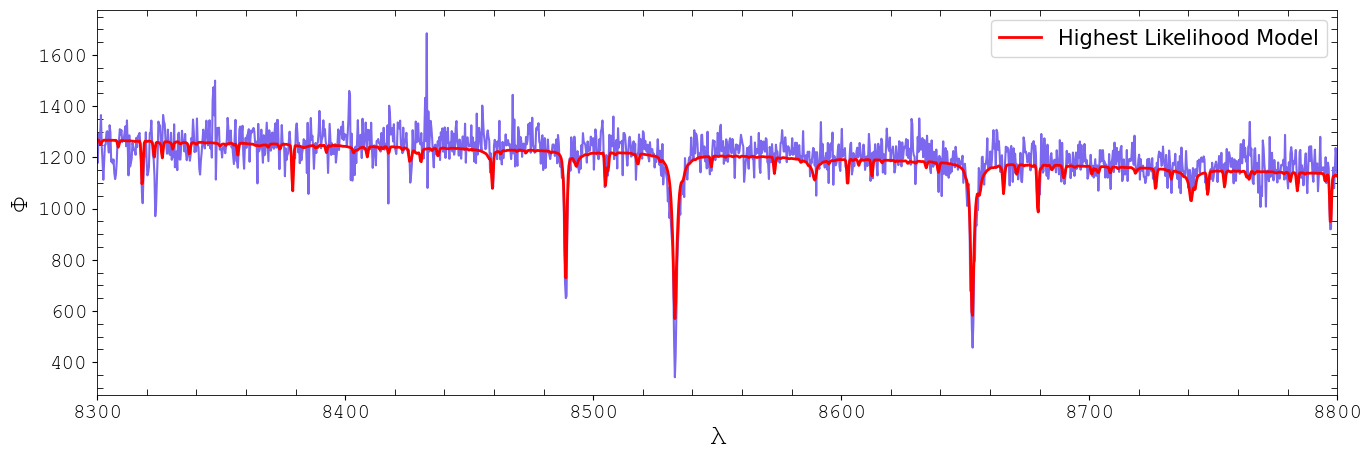

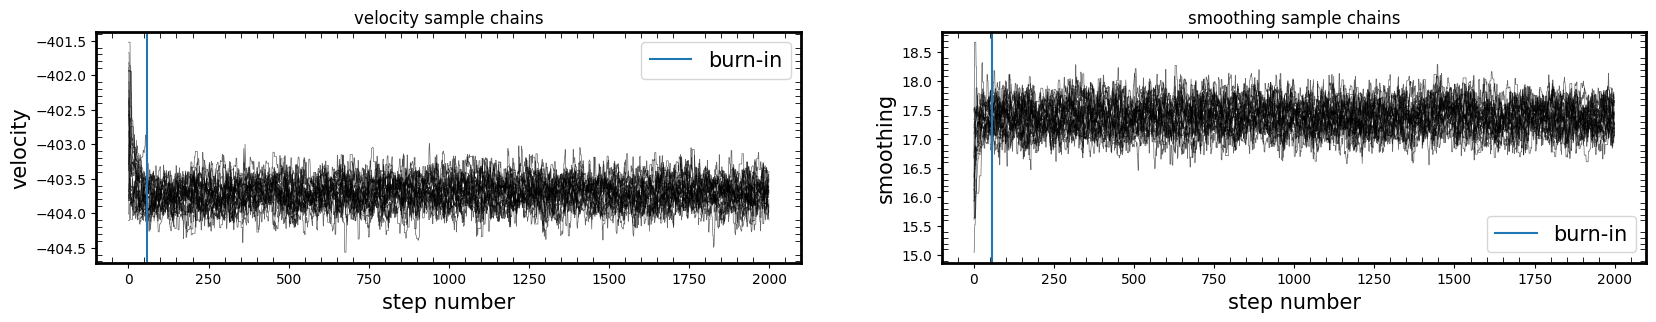

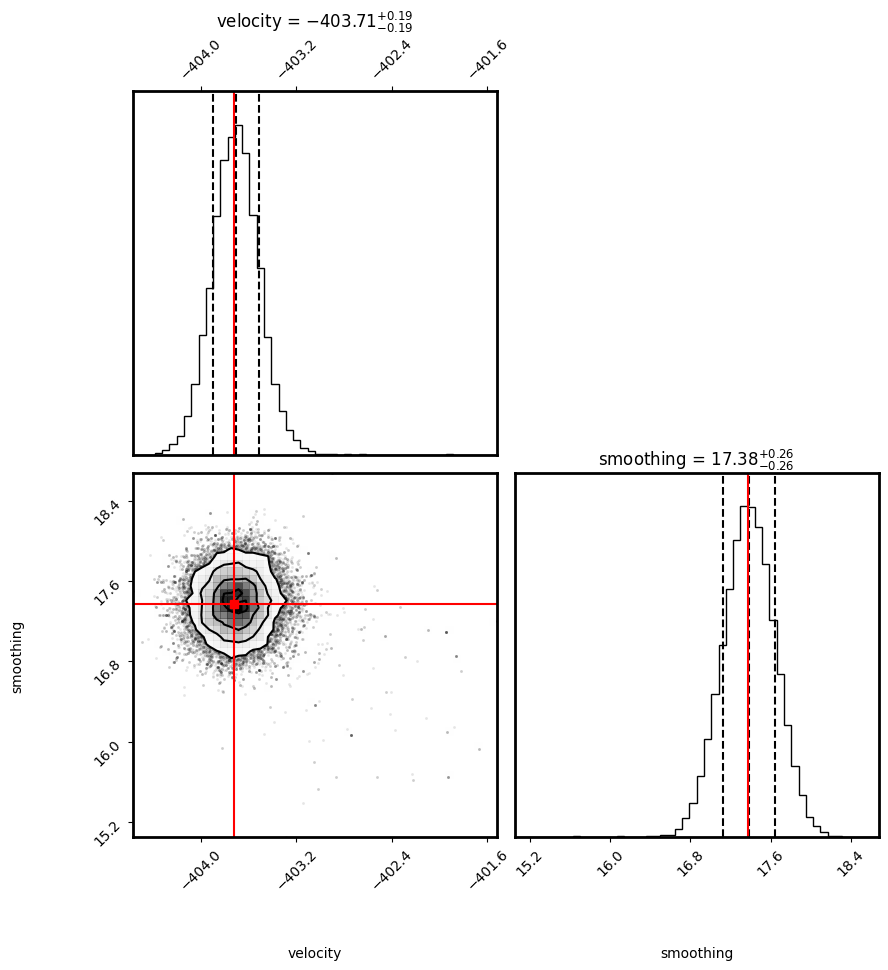

In [80]:
MCMC(pwave, pflux, SPAT121w, SPAT121f, SPAT121var, -400, 14)

Running burn-in...


100%|█████████████████████████████████████████| 100/100 [00:22<00:00,  4.44it/s]


Running production...


100%|███████████████████████████████████████| 2000/2000 [07:11<00:00,  4.63it/s]


converged:  True
[wavelength, velocity]:  [-405.96057418   14.71080637]


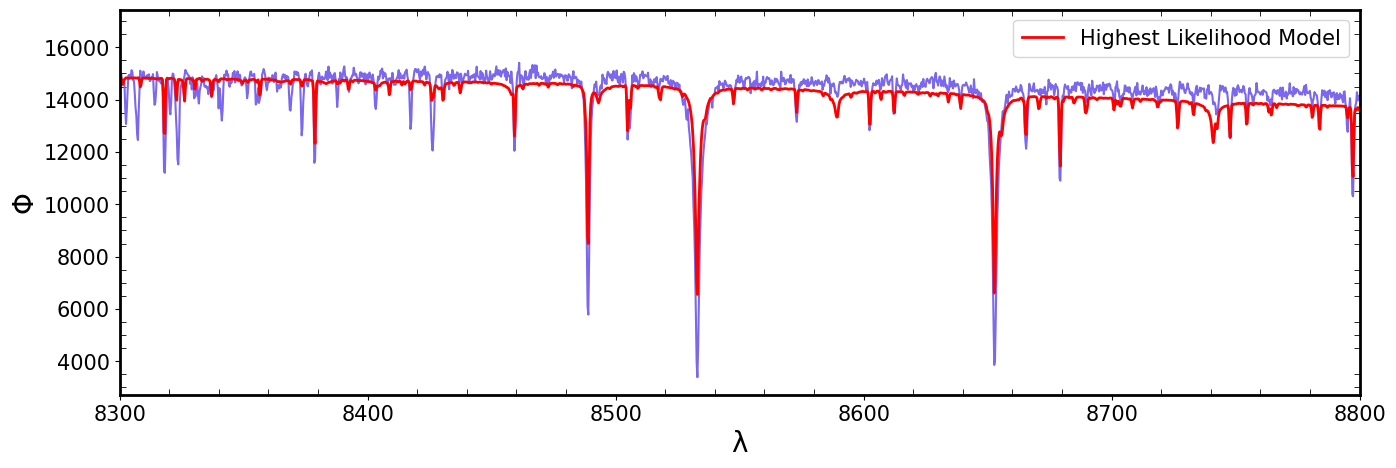

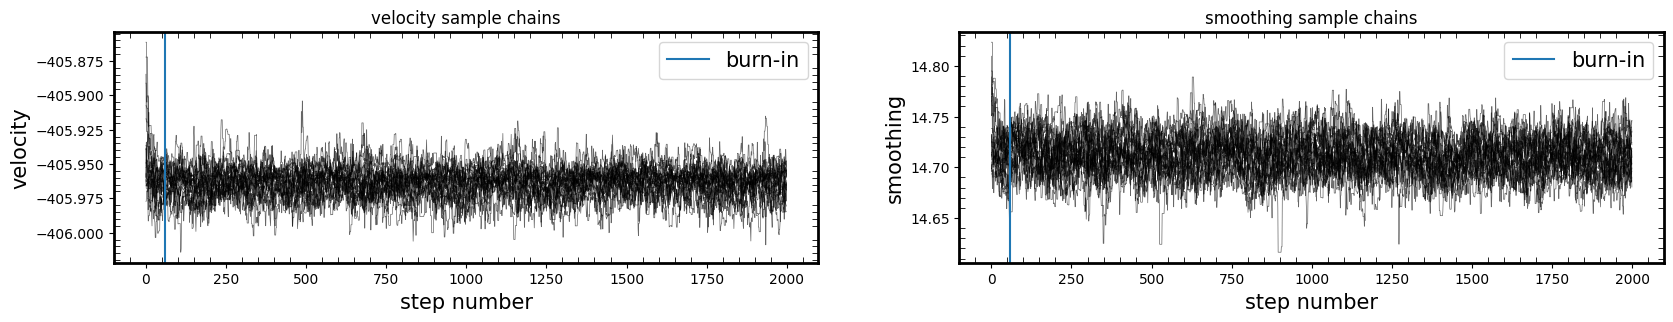

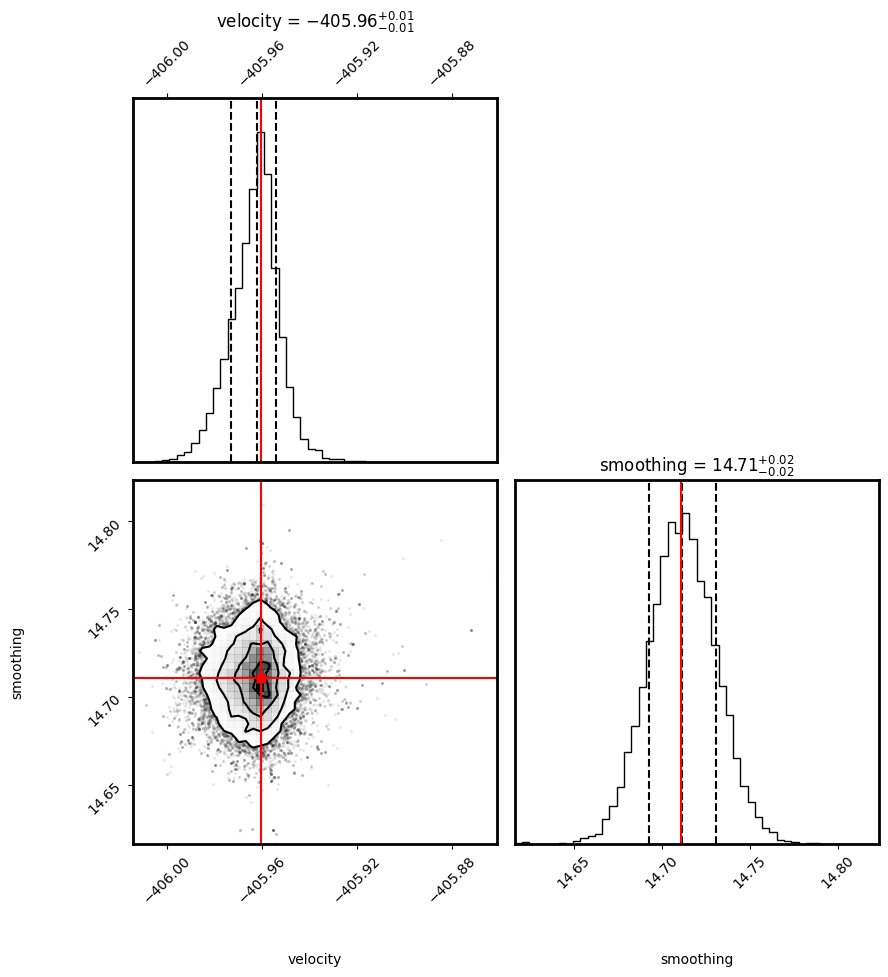

In [83]:
MCMC(pwave, pflux, SPAT135w, SPAT135f, SPAT135var, -405, 16)